# Sentiment Analysis with IMDB

**Module 02 | Notebook 2 of 3**

In this notebook, we'll build a complete sentiment analysis system using the IMDB movie review dataset.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Handle large text datasets efficiently
2. Implement proper train/validation splits
3. Use evaluation metrics (accuracy, F1, precision, recall)
4. Analyze model performance and errors

---

In [1]:
%%capture
!pip install transformers datasets accelerate evaluate scikit-learn matplotlib seaborn

In [2]:
import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import load_dataset
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## Load and Explore the Dataset

In [3]:
# Load IMDB dataset
dataset = load_dataset("imdb")

print("Dataset structure:")
print(dataset)
print(f"\nTrain examples: {len(dataset['train']):,}")
print(f"Test examples: {len(dataset['test']):,}")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Train examples: 25,000
Test examples: 25,000


In [4]:
# Explore the data
print("Label distribution:")
train_labels = dataset['train']['label']
pos_count = sum(train_labels)
neg_count = len(train_labels) - pos_count
print(f"  Positive: {pos_count:,} ({pos_count/len(train_labels):.1%})")
print(f"  Negative: {neg_count:,} ({neg_count/len(train_labels):.1%})")

Label distribution:
  Positive: 12,500 (50.0%)
  Negative: 12,500 (50.0%)



Text length statistics (words):
  Min: 10
  Max: 2470
  Mean: 234
  Median: 174


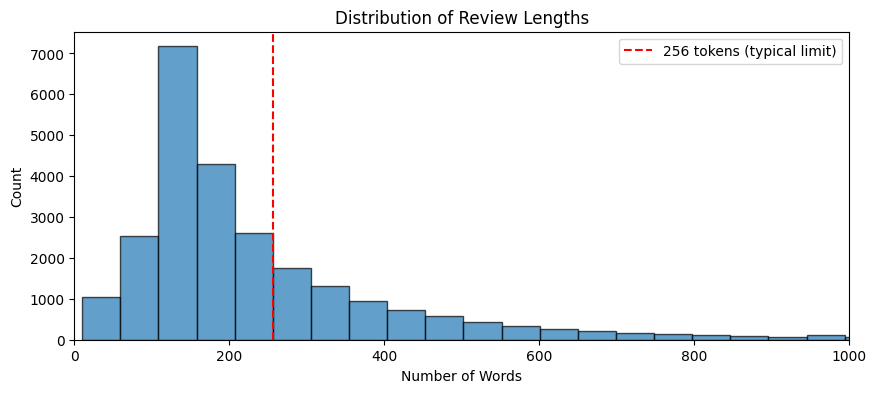

In [5]:
# Analyze text lengths
text_lengths = [len(text.split()) for text in dataset['train']['text']]

print("\nText length statistics (words):")
print(f"  Min: {min(text_lengths)}")
print(f"  Max: {max(text_lengths)}")
print(f"  Mean: {np.mean(text_lengths):.0f}")
print(f"  Median: {np.median(text_lengths):.0f}")

# Plot distribution
plt.figure(figsize=(10, 4))
plt.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=256, color='r', linestyle='--', label='256 tokens (typical limit)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Review Lengths')
plt.legend()
plt.xlim(0, 1000)
plt.show()

In [6]:
# Sample reviews
print("Sample Positive Review:")
print("-" * 50)
pos_example = dataset['train'].filter(lambda x: x['label'] == 1)[0]
print(pos_example['text'][:500] + "...")

print("\nSample Negative Review:")
print("-" * 50)
neg_example = dataset['train'].filter(lambda x: x['label'] == 0)[0]
print(neg_example['text'][:500] + "...")

Sample Positive Review:
--------------------------------------------------


Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is ...

Sample Negative Review:
--------------------------------------------------


Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent...


---

## Data Preparation

For faster training in this demo, we'll use a subset. In production, use the full dataset.

In [7]:
# Create subsets for faster training (increase for better results)
train_size = 2000
test_size = 500

# Balanced sampling
train_data = dataset['train'].shuffle(seed=42).select(range(train_size))
test_data = dataset['test'].shuffle(seed=42).select(range(test_size))

# Create validation split from training data
train_val_split = train_data.train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_data)}")

Training samples: 1800
Validation samples: 200
Test samples: 500


In [8]:
# Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding=True,
        truncation=True,
        max_length=256  # IMDB reviews can be long
    )

# Tokenize all datasets
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_data.map(tokenize_function, batched=True)

print("Tokenization complete!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenization complete!


---

## Model Training

In [9]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 66,955,010


In [10]:
# Define comprehensive metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    
    return {
        'accuracy': accuracy.compute(predictions=preds, references=labels)['accuracy'],
        'f1': f1.compute(predictions=preds, references=labels)['f1'],
        'precision': precision.compute(predictions=preds, references=labels)['precision'],
        'recall': recall.compute(predictions=preds, references=labels)['recall']
    }

In [11]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./imdb_sentiment_model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=25,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [12]:
# Train
print("Starting training...")
trainer.train()
print("\nTraining complete!")

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.422600,0.363389,0.845000,0.845771,0.787037,0.913978
2,0.314800,0.378222,0.865000,0.866995,0.800000,0.946237
3,0.140300,0.404495,0.865000,0.862944,0.817308,0.913978



Training complete!


---

## Evaluation and Analysis

In [13]:
# Evaluate on test set
test_results = trainer.evaluate(test_tokenized)

print("Test Set Results:")
print("=" * 40)
print(f"Accuracy:  {test_results['eval_accuracy']:.2%}")
print(f"F1 Score:  {test_results['eval_f1']:.2%}")
print(f"Precision: {test_results['eval_precision']:.2%}")
print(f"Recall:    {test_results['eval_recall']:.2%}")

Test Set Results:
Accuracy:  86.80%
F1 Score:  87.55%
Precision: 81.69%
Recall:    94.31%


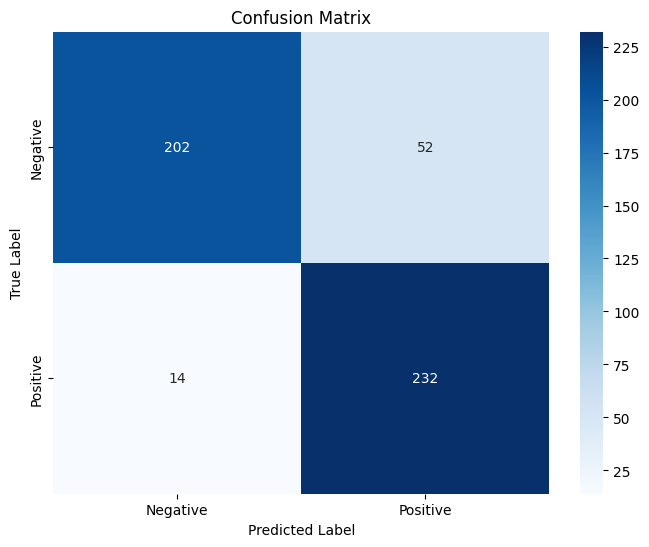


Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.80      0.86       254
    Positive       0.82      0.94      0.88       246

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500



In [14]:
# Get predictions for confusion matrix
predictions = trainer.predict(test_tokenized)
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=['Negative', 'Positive']))

---

## Error Analysis

Understanding where the model fails helps improve it.

In [18]:
# Find misclassified examples
test_texts = test_data['text']
misclassified_indices = np.where(preds != true_labels)[0]

print(f"Misclassified: {len(misclassified_indices)} out of {len(true_labels)} ({len(misclassified_indices)/len(true_labels):.1%})")
print("\n" + "=" * 60)
print("Sample Misclassified Reviews:")
print("=" * 60)

for idx in misclassified_indices[:3]:
    idx = int(idx)  # Convert numpy.int64 to Python int
    true_label = "Positive" if true_labels[idx] == 1 else "Negative"
    pred_label = "Positive" if preds[idx] == 1 else "Negative"
    
    print(f"\nTrue: {true_label} | Predicted: {pred_label}")
    print(f"Text: {test_texts[idx][:300]}...")
    print("-" * 60)

Misclassified: 66 out of 500 (13.2%)

Sample Misclassified Reviews:

True: Negative | Predicted: Positive
Text: Coming from Kiarostami, this art-house visual and sound exposition is a surprise. For a director known for his narratives and keen observation of humans, especially children, this excursion into minimalist cinematography begs for questions: Why did he do it? Was it to keep him busy during a vacation...
------------------------------------------------------------

True: Negative | Predicted: Positive
Text: Intended as light entertainment, this film is indeed successful as such during its first half, but then succumbs to a rapidly foundering script that drops it down. Harry (Judd Nelson), a "reformed" burglar, and Daphne (Gina Gershon), an aspiring actress, are employed as live window mannequins at a d...
------------------------------------------------------------

True: Negative | Predicted: Positive
Text: "An astronaut (Michael Emmet) dies while returning from a mission and 

---

## Interactive Testing

In [17]:
from transformers import pipeline

# Create inference pipeline
sentiment_classifier = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Test examples
test_reviews = [
    "This movie is a masterpiece. The acting, direction, and story are all perfect.",
    "Absolute garbage. Waste of 2 hours of my life. Avoid at all costs.",
    "It was okay. Some good moments but overall forgettable.",
    "Not as good as the original, but still entertaining enough."
]

print("Live Predictions:")
print("=" * 60)
for review in test_reviews:
    result = sentiment_classifier(review)[0]
    emoji = "😊" if result['label'] == "POSITIVE" else "😠"
    print(f"{emoji} {result['label']} ({result['score']:.2%})")
    print(f"   {review[:60]}...\n")

Device set to use cuda:0


Live Predictions:
😊 POSITIVE (96.54%)
   This movie is a masterpiece. The acting, direction, and stor...

😠 NEGATIVE (96.81%)
   Absolute garbage. Waste of 2 hours of my life. Avoid at all ...

😠 NEGATIVE (66.99%)
   It was okay. Some good moments but overall forgettable....

😊 POSITIVE (67.13%)
   Not as good as the original, but still entertaining enough....



---

## 🎯 Student Challenge

### Challenge: Improve Model Performance

Try these strategies to improve the model:

In [ ]:
# TODO: Experiment with these improvements:

# 1. Use more training data (increase train_size)
# 2. Try a different base model (e.g., "bert-base-uncased", "roberta-base")
# 3. Adjust hyperparameters (learning rate, batch size, epochs)
# 4. Increase max_length for longer reviews

# Track your improvements:
# | Change | Accuracy | F1 |
# |--------|----------|----|
# | Baseline | ... | ... |

# Your solution:


---

## Key Takeaways

1. **Data exploration** is crucial before training
2. **Balanced datasets** lead to better model performance
3. **Multiple metrics** (accuracy, F1, precision, recall) give complete picture
4. **Error analysis** helps identify model weaknesses
5. **Confusion matrices** visualize classification errors

---

## Next Steps

Continue to `03_summarization.ipynb` for sequence-to-sequence tasks!